In [1]:
import sys
sys.path.insert(0,'/home/robin/Projects/sciunit')
sys.path.insert(0,'/home/robin/Projects/INM6/elephant')
sys.path.append('/home/robin/Projects/INM6/python-neo')
sys.path.append('/home/robin/Projects/NetworkUnit')
sys.path.append('/home/robin/Projects/INM6/Tasks')
import sciunit
from networkunit import scores, models, tests, plots, capabilities
from networkunit.plots import alpha
from neo.core import SpikeTrain
from quantities import ms, Hz
import matplotlib.pyplot as plt
from matplotlib import rc, rcParams
import seaborn as sns
import numpy as np
from simplejson import load as jsonload
from requests import get
from time import time
import os
from copy import copy
from elephant.statistics import mean_firing_rate
from abc import ABCMeta, abstractmethod, abstractproperty
rc('text', usetex=True)
sns.set(style='ticks', palette='Set2', context='poster')

### Test Network

In [2]:
size = 100
rate = 10*Hz
tstart = 0*ms
tstop = 10000*ms
binsize = 2*ms
max_pattern_length = 50 * ms
cc= .5
A = [20,20]

model_st = models.stochastic_activity(size=size, correlations=cc, assembly_sizes=A,
                                correlation_method='spatio-temporal', t_start=tstart, t_stop=tstop,
                                shuffle=False, max_pattern_length=max_pattern_length,
                                name='', color=sns.color_palette('Set2')[2])
for count, a in enumerate(A):
    for i in range(a):
        if count:
            b=A[count-1]
        else:
            b=0
        model_st.spiketrains[b+i].annotations['Assembly'] = 'A_{}'.format(count)

/usr/local/lib/python2.7/dist-packages/quantities/quantity.py:321: RuntimeWarning: divide by zero encountered in true_divide
  return np.true_divide(other, self)


### Test

In [3]:
class spatio_temp_test(sciunit.TestM2M, tests.generalized_correlation_matrix_test):
    score_type = scores.weighted_angle
    params = {'graph_measure': None, # degree strength, closeness, betweenness, edge betweenness, katz centrality
              'edge_threshold': 0.05, 
              'maxlag': 50,  # in bins
              'binsize': 2 * ms,
              'bin_num': 5000,
              'time_reduction': 'lag 0', # sum, max, threshold x
              'cluster_matrix': False,
              'cluster_method': 'ward',
              }
    def compute_score(self, prediction1, prediction2):
        score = self.score_type.compute(prediction1, prediction2, **self.params)
        return score

In [4]:
st_test = spatio_temp_test()

In [5]:
st_test.generate_prediction(model_st)

array([[  1.00000000e+00,   2.68978390e-03,   2.05172335e-02, ...,
          2.38898615e-04,   1.12917664e-02,  -5.08322896e-04],
       [  2.68978390e-03,   1.00000000e+00,   1.15943928e-02, ...,
         -1.97612461e-02,  -8.60108032e-03,   1.29809678e-04],
       [  2.05172335e-02,   1.15943928e-02,   1.00000000e+00, ...,
          8.45607414e-03,   1.93267479e-02,  -1.92102978e-03],
       ..., 
       [  2.38898615e-04,  -1.97612461e-02,   8.45607414e-03, ...,
          1.00000000e+00,  -5.77962712e-04,  -1.17879988e-02],
       [  1.12917664e-02,  -8.60108032e-03,   1.93267479e-02, ...,
         -5.77962712e-04,   1.00000000e+00,  -1.32693039e-03],
       [ -5.08322896e-04,   1.29809678e-04,  -1.92102978e-03, ...,
         -1.17879988e-02,  -1.32693039e-03,   1.00000000e+00]])

### CCH space plot

<IPython.core.display.Javascript object>


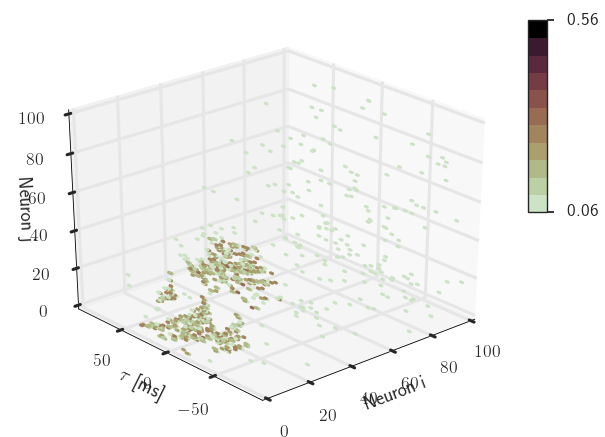

value dropped
border value shifted
value dropped
border value shifted
value dropped
value dropped
value dropped
value dropped
0.56291824823


In [6]:
%matplotlib nbagg
st_test.plot_cch_space(model_st, threshold=0.06)
plt.tight_layout()
plt.show()

In [7]:
plt.savefig('/home/robin/Sciebo/Documents/Thesis/Figures/cch_space.pdf', bbox_inches='tight')

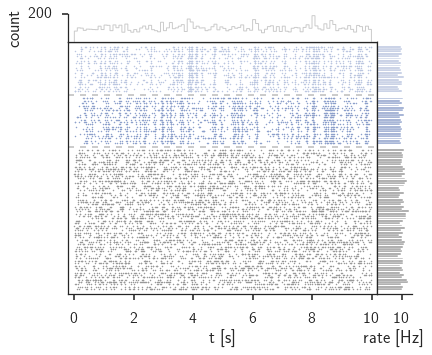

In [12]:
%matplotlib inline
sns.set(style='ticks', palette='Set2', context='poster')
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,5))
fig.tight_layout()

palette = [alpha('#000000',.4), sns.color_palette('Set2')[2], alpha(sns.color_palette('Set2')[2],.6)]

ax, axhistx, axhisty = plots.rasterplot(model_st.spiketrains, ax=ax, palette=palette, spacing=2, pophist_mode='total',
                        key_list=['Assembly'], groupingdepth=1, colorkey='Assembly', context='poster',
                                       markerargs={'markersize':3,'marker':'.'})
ax.set_xticklabels([0,0,2,4,6,8,10])
axhisty.set_xticks([0.01])
axhisty.set_xticklabels([10])
axhisty.set_xlabel('rate [Hz]')
axhistx.set_ylabel('count')
ax.set_xlabel('t [s]')
plt.savefig('/home/robin/Sciebo/Documents/Thesis/Figures/rasterplot_spatio-temporal_for_cch.pdf', bbox_inches='tight')

### Cross-Correlation Histogramm

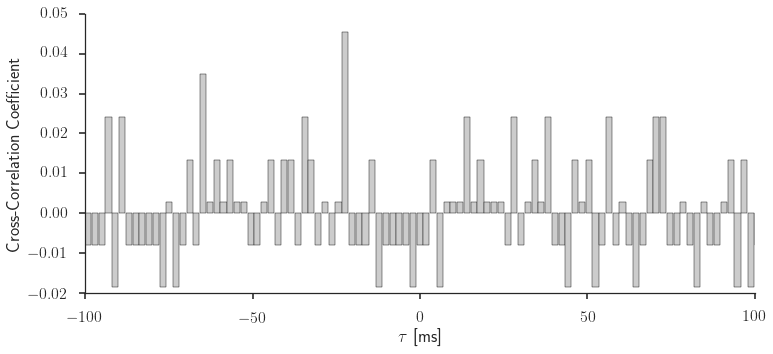

In [15]:
sns.set(style='ticks', palette='Set2', context='poster')
ccharray = model_st.cch_array['binsize{}_maxlag{}'.format(binsize, st_test.params['maxlag'])]

B = len(ccharray[0])
x = np.linspace(-B/2,B/2,B)*2
fig, ax = plt.subplots(1,1, figsize=(12,5), sharey=True)


ax.bar(x, ccharray[80], width=(x[1]-x[0])*.9, color='0.8')
# ax.bar([-11], ccharray[80][95], width=(x[1]-x[0])*1, color='r')
# ax.bar([-11], [0.05], width=(x[1]-x[0])*1, color='0.8')
# ax.bar([21], ccharray[80][111], width=(x[1]-x[0])*1, color='r')
# ax.bar([21], [0.05], width=(x[1]-x[0])*1, color='0.8')
# ax.axhline(0.05)
sns.despine()
ax.set_xlim((-100,100))
ax.set_xlabel(r'$\tau$ [ms]')
ax.set_ylabel('Cross-Correlation Coefficient')
plt.savefig('/home/robin/Sciebo/Documents/Thesis/Figures/cch_example.pdf', bbox_inches='tight')
plt.show()

### Population CCH

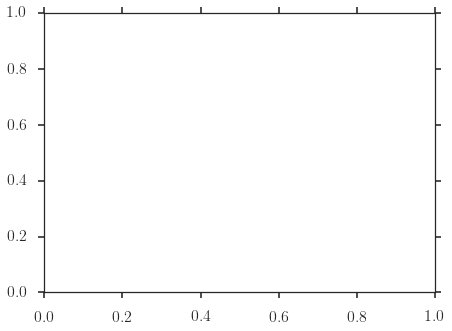

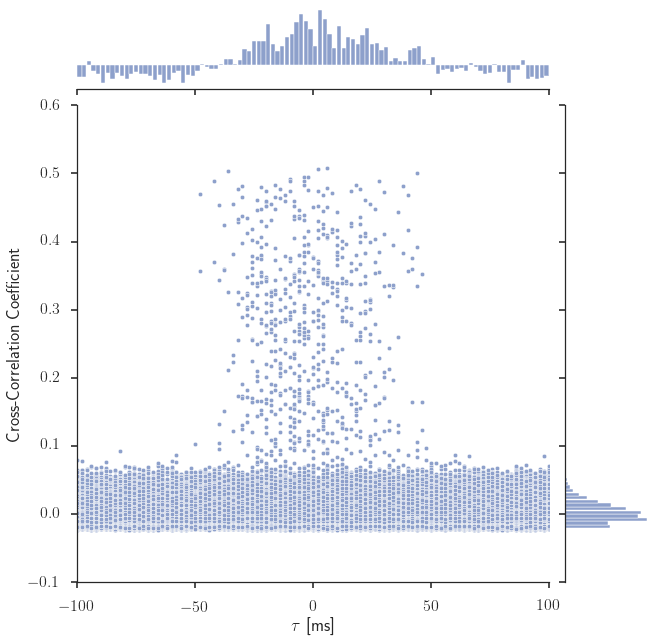

In [17]:
sns.set(style='ticks', palette='Set2', context='poster')
fig, ax = plt.subplots(1,1, figsize=(7,5))
g = st_test.draw_pop_cch(model_st, figsize=9, color=sns.color_palette('Set2')[2], ax=ax)
plt.savefig('/home/robin/Sciebo/Documents/Thesis/Figures/pop_cch_example.pdf', bbox_inches='tight')
plt.show()

### CCC-Matrix

In [10]:
class sum_mat(spatio_temp_test):
    score_type = scores.weighted_angle
    params = copy(spatio_temp_test.params)
    params.update(time_reduction='sum')

class max_mat(spatio_temp_test):
    score_type = scores.weighted_angle
    params = copy(spatio_temp_test.params)
    params.update(time_reduction='max', cluster_matrix=False)

class th_mat(spatio_temp_test):
    score_type = scores.weighted_angle
    params = copy(spatio_temp_test.params)
    params.update(time_reduction='threshold 0.05')

test_sum = sum_mat()
test_max = max_mat()
test_th = th_mat()

print test_sum.generate_prediction(model_st)
print test_max.generate_prediction(model_st)
print test_th.generate_prediction(model_st)

vmin=-.5
vmax=.8

[[  1.00000000e+00   7.41312983e-01   4.10563574e-01 ...,  -1.15228765e-01
    1.02826720e-02   7.57401116e-02]
 [  7.41312983e-01   1.00000000e+00   4.79416580e-01 ...,  -4.41323480e-02
    1.92623999e-04   9.42418260e-02]
 [  4.10563574e-01   4.79416580e-01   1.00000000e+00 ...,  -2.71087258e-03
   -5.83549897e-02   1.65223687e-01]
 ..., 
 [ -1.15228765e-01  -4.41323480e-02  -2.71087258e-03 ...,   1.00000000e+00
    1.07594788e-01   7.67354838e-02]
 [  1.02826720e-02   1.92623999e-04  -5.83549897e-02 ...,   1.07594788e-01
    1.00000000e+00  -9.38055417e-03]
 [  7.57401116e-02   9.42418260e-02   1.65223687e-01 ...,   7.67354838e-02
   -9.38055417e-03   1.00000000e+00]]
[[ 1.          0.34424964  0.4185237  ...,  0.04005533  0.0415646
   0.04836888]
 [ 0.34424964  1.          0.26966047 ...,  0.04219918  0.05421109
   0.04069533]
 [ 0.4185237   0.26966047  1.         ...,  0.04696279  0.0583628
   0.0453484 ]
 ..., 
 [ 0.04005533  0.04219918  0.04696279 ...,  1.          0.05799934
  

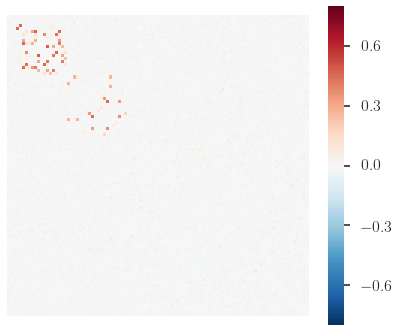

In [15]:
sns.set(style='ticks', palette='Set2', context='poster')
fig, ax = plt.subplots(1,1, figsize=(6,5))
st_test.visualize_samples(model_st, vmin=vmin, vmax=vmax, show_colorbar=False, ax=ax)
plt.gca().set_xticks([])
plt.gca().set_yticks([])
plt.tight_layout()
plt.savefig('/home/robin/Sciebo/Documents/Thesis/Figures/ccc_mat_lag0.pdf', bbox_inches='tight')
plt.show()

1.0


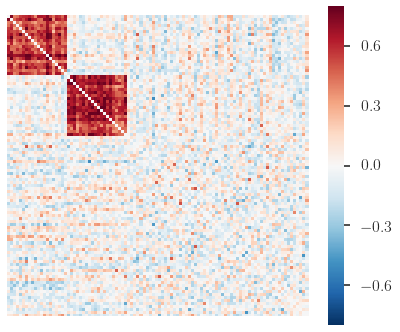

In [17]:
sns.set(style='ticks', palette='Set2', context='poster')
fig, ax = plt.subplots(1,1, figsize=(6,5))

test_sum.visualize_samples(model_st, vmin=vmin, vmax=vmax, show_colorbar=False, ax=ax)
print np.max(test_sum.generate_prediction(model_st))
plt.gca().set_xticks([])
plt.gca().set_yticks([])
plt.tight_layout()
plt.savefig('/home/robin/Sciebo/Documents/Thesis/Figures/ccc_mat_sum.pdf', bbox_inches='tight')
plt.show()

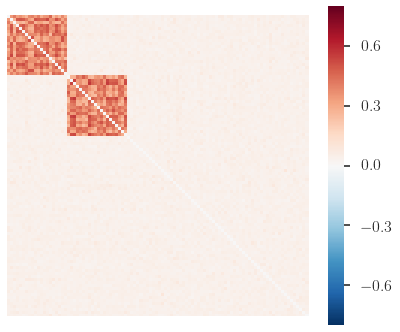

In [18]:
sns.set(style='ticks', palette='Set2', context='poster')
fig, ax = plt.subplots(1,1, figsize=(6,5))

test_max.visualize_samples(model_st, vmin=vmin, vmax=vmax, show_colorbar=False, ax=ax)
plt.gca().set_xticks([])
plt.gca().set_yticks([])
plt.tight_layout()
plt.savefig('/home/robin/Sciebo/Documents/Thesis/Figures/ccc_mat_max.pdf', bbox_inches='tight')
plt.show()

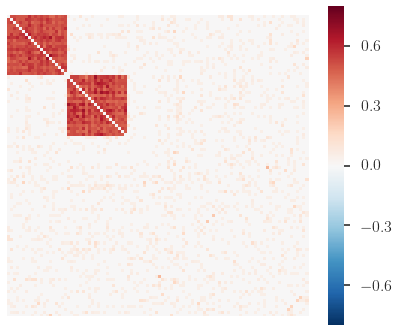

In [19]:
sns.set(style='ticks', palette='Set2', context='poster')
fig, ax = plt.subplots(1,1, figsize=(6,5))

test_th.visualize_samples(model_st, vmin=vmin, vmax=vmax, show_colorbar=False, ax=ax)
plt.gca().set_xticks([])
plt.gca().set_yticks([])
plt.tight_layout()
plt.savefig('/home/robin/Sciebo/Documents/Thesis/Figures/ccc_mat_th.pdf', bbox_inches='tight')
plt.show()

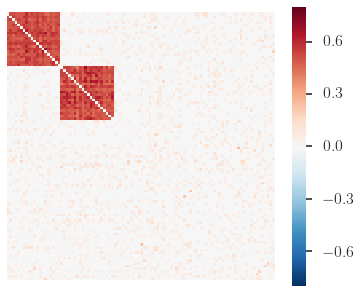

In [20]:
sns.set(style='ticks', palette='Set2', context='poster')
fig, ax = plt.subplots(1,1, figsize=(6,5))

test_th.visualize_samples(model_st, vmin=vmin, vmax=vmax, show_colorbar=True,ax=ax)
plt.gca().set_xticks([])
plt.gca().set_yticks([])
plt.savefig('/home/robin/Sciebo/Documents/Thesis/Figures/ccc_cbar.pdf', bbox_inches='tight')
plt.show()